In [44]:
# https://github.com/stanfordnlp/GloVe
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
# https://github.com/keshavbhandari/Unsupervised-Learning-With-Glove-Word-Embeddings-on-Search-Queries/blob/master/Glove_Clustering.py
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

import numpy as np
import pandas as pd
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import KeyedVectors

In [32]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cemul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cemul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cemul\AppData\Roaming\nltk_data...


True

### Importing Glove Embeddings

In [2]:
# defining relative paths
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
data_dir = os.path.join(parent_dir, "Data")
glove_dir = os.path.join(data_dir,"glove")
glove_file = "glove.twitter.27B.200d.txt"
glove_path =  os.path.join(glove_dir,glove_file)

In [3]:
embeddings_dict = {}
with open(glove_path, 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [6]:
del embeddings_dict['-0.29736']

In [7]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))


In [8]:
find_closest_embeddings(embeddings_dict["turkish"])[1:5]

['turkey', 'lebanese', 'ukrainian', 'azerbaijan']

### Further Cleaning Data for Creating Embeddings

In [9]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_english_cleaned_without_mentions.tsv'), delimiter='\t')
test_df = pd.read_csv(os.path.join(data_dir, 'test_english_cleaned_without_mentions.tsv'), delimiter='\t')

In [10]:
train_df

,tweet_text,check_worthiness
0,Since this will never get reported by the medi...,1
1,"Thanks, MichaelBloomberg. Here’s a handy littl...",0
2,"Folks, when you say ""The COVID-19 isn't a big ...",0
3,Just 1 case of COVID-19 in India and people ar...,0
4,President made a commitment to donate his sala...,1
...,...,...
817,Stop spreading fake news COVID-19,0
818,It's fake! It's fake!' shout residents of a co...,1
819,Be Smart about COVID-19: 1⃣ follow accurate pu...,0
820,"On the left: , a Qatari puppet, attacks Saudi ...",1


In [11]:
def clean_text(df, column_name):
    stop = stopwords.words('english')
    df[column_name] = df[column_name].str.lower() #Lower case
    df[column_name] = df[column_name].str.replace(r'\d', '') #Remove numbers
    df[column_name] = df[column_name].str.replace(r'[^\w\s]+', ' ') #Punctuation
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #Remove stopwords
    return df
    

In [162]:
test_df = clean_text(test_df, "tweet_text")

C:\Users\cemul\AppData\Local\Temp\ipykernel_24836\3342062777.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'\d', '') #Remove numbers
C:\Users\cemul\AppData\Local\Temp\ipykernel_24836\3342062777.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'[^\w\s]+', ' ') #Punctuation


In [12]:
train_df = clean_text(train_df, "tweet_text")
train_df

C:\Users\cemul\AppData\Local\Temp\ipykernel_24836\3342062777.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'\d', '') #Remove numbers
C:\Users\cemul\AppData\Local\Temp\ipykernel_24836\3342062777.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column_name] = df[column_name].str.replace(r'[^\w\s]+', ' ') #Punctuation


,tweet_text,check_worthiness
0,since never get reported media wanted share co...,1
1,thanks michaelbloomberg handy little unintenti...,0
2,folks say covid big deal kills disabled elderl...,0
3,case covid india people crazy masks daily peop...,0
4,president made commitment donate salary office...,1
...,...,...
817,stop spreading fake news covid,0
818,fake fake shout residents community covid epic...,1
819,smart covid follow accurate public health advi...,0
820,left qatari puppet attacks saudi arabia tempor...,1


In [37]:
wnl = WordNetLemmatizer()
def lemmatize_sentence(sentence):
    text = list()
    for word, tag in nltk.pos_tag(str.split(sentence)):
        if tag.startswith("NN"):
            text.append( wnl.lemmatize(word, pos='n'))
        elif tag.startswith('VB'):
            text.append( wnl.lemmatize(word, pos='v'))
        elif tag.startswith('JJ'):
            text.append( wnl.lemmatize(word, pos='a'))
        else:
            text.append( word)
    return ' '.join(text)  

In [163]:
test_df["tweet_text"] = test_df["tweet_text"].apply(lambda sentence: ' '.join([lemmatize_sentence(sentence)]))

In [40]:
train_df["tweet_text"] = train_df["tweet_text"].apply(lambda sentence: ' '.join([lemmatize_sentence(sentence)]))
train_df

,tweet_text,check_worthiness
0,since never get reported medium want share cop...,1
1,thanks michaelbloomberg handy little unintenti...,0
2,folk say covid big deal kill disable elderly c...,0
3,case covid india people crazy mask daily peopl...,0
4,president make commitment donate salary office...,1
...,...,...
817,stop spread fake news covid,0
818,fake fake shout resident community covid epice...,1
819,smart covid follow accurate public health advi...,0
820,leave qatari puppet attack saudi arabia tempor...,1


In [46]:
def get_non_glove_words(dataframe, column, embeddings_dict):

    # Unique Words
    counts = dataframe[column].str.split(expand=True).stack().value_counts(dropna=False).rename_axis('unique_words').reset_index(name='counts')
    
    # Extracting Glove Words and Non Glove Words
    non_glove_words = list()
    glove_words = list()
    for i in counts['unique_words']:
        try:
            embeddings_dict[i]
        except KeyError:
            non_glove_words.append(i)
        else:
            glove_words.append(i)
    
    #Non-Glove words
    non_glove_words_df = pd.DataFrame({'unique_non_glove_words':non_glove_words})
    non_glove_words_df = pd.merge(non_glove_words_df,counts,how='left',left_on=['unique_non_glove_words'],right_on=['unique_words']).iloc[:,[0,2]]
    non_glove_words_df['cum_perc'] = round(100*non_glove_words_df["counts"].cumsum()/non_glove_words_df["counts"].sum(),2)
    
    print('Done')
    
    return(non_glove_words_df)

In [48]:
non_glove_words_df =get_non_glove_words(train_df, "tweet_text", embeddings_dict)

Done


In [51]:
non_glove_words_df.unique_non_glove_words.values

array(['covid', 'coronavirusoutbreak', 'coronaalert', 'coronaoutbreak',
       'coronavirusupdate', 'coronavirusindia', 'epidemiologist',
       'koronawirus', 'underfunding', 'chloroquine', 'coronavirusturkey',
       'coronavirusitalia', 'indiafightscorona', 'kyari', 'ppes',
       'coronvirus', 'fakenewsmedia', 'nurtw', 'nofakenews',
       'pibfactcheck', 'wuhanvirus', 'americafirst', 'trumpcrash',
       'supertuesday', 'flattenthecurve', 'trumpvirus', 'fauci', 'lhota',
       'justicefordrcarlos', 'notoviptesting', 'teleworking',
       'nationalguard', 'ccpvirus', 'shalomnamaste', 'covidon',
       'getmeppe', 'nmasks', 'ehhhh', 'petrify', 'zhangyixing',
       'fakescience', 'pharmafauci', 'rathee', 'mishandle',
       'covidnigeria', 'takingoncorona', 'notahoax', 'militarytrain',
       'forcedisolation', 'foxclassaction', 'complacence',
       'hydroxychloroquine', 'arrhythmias', 'plaquenil', 'withhealth',
       'tulirogwa', 'agaings', 'withtheir', 'overburden',
       'coro

In [159]:

def get_average_text_embedding(sentence):
    token_list = str.split(sentence)
    embedding_list = []
    for token in token_list:
        try:
            embedding = embeddings_dict[token]
            embedding_list.append(embedding)
        except:
            continue
    embedding_array = np.array(embedding_list)
    averaged_array = np.average(embedding_array, axis=0)

    if len(embedding_list)==0:
        averaged_array = np.zeros(200)
    
    return averaged_array


In [164]:
test_df['tweet_embeddings'] = test_df['tweet_text'].apply(lambda x: get_average_text_embedding(x))

In [160]:
train_df['tweet_embeddings'] = train_df['tweet_text'].apply(lambda x: get_average_text_embedding(x))
train_df[541:]

c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


,tweet_text,check_worthiness,tweet_embeddings
541,,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
542,today lose colleague young adult cardiology fe...,0,"[-0.01190776, 0.081272185, -0.116894156, -0.05..."
543,china time people italy,0,"[0.13480301, 0.03470476, 0.19799125, -0.034149..."
544,please remember future job interview ask compa...,0,"[0.032589354, 0.02450451, -0.20642322, -0.0113..."
545,flintstone gummies year ago fight covid,0,"[0.178236, -0.14855798, 0.14696935, 0.1620584,..."
...,...,...,...
817,stop spread fake news covid,0,"[-0.21876001, 0.1594845, -0.3555225, -0.181262..."
818,fake fake shout resident community covid epice...,1,"[-0.13164519, 0.035182584, -0.20567551, -0.021..."
819,smart covid follow accurate public health advi...,0,"[-0.13120344, 0.107465036, -0.29263848, -0.141..."
820,leave qatari puppet attack saudi arabia tempor...,1,"[0.02632392, 0.075065166, -0.05794293, 0.02835..."


In [167]:
eval_df = pd.read_csv(os.path.join(data_dir,"eval_df.csv"))

In [169]:
test_df

,tweet_text,check_worthiness,tweet_embeddings
0,potus want everyone know close contact gaetz c...,1,"[0.16674243, 0.3065092, -0.112421855, 0.048177..."
1,would prefer lead nation response grow covid t...,0,"[0.22938012, 0.054673575, -0.0858, -0.07526214..."
2,really really really really really really real...,0,"[0.03409792, 0.45846257, -0.015111784, 0.25196..."
3,bald face lie self quarantine cdc clear return...,1,"[0.008557552, -0.16238855, -0.34488454, 0.0608..."
4,live daily medium brief covid covid,0,"[-0.4223225, 0.272865, -0.1823175, -0.44944727..."
...,...,...,...
135,covid spread fast spreads natural immunity vir...,0,"[-0.010497776, -0.110912405, -0.053065408, -0...."
136,market crash tourism die travel reduce almost ...,0,"[-0.0055288733, 0.30287853, -0.058681164, -0.0..."
137,pray palestine state emergency case covid majo...,0,"[-0.108859845, 0.18808445, 0.0026538572, 0.043..."
138,advisory student class suspension make safety ...,0,"[0.105307795, 0.12508944, 0.03175255, -0.10886..."


In [171]:
eval_df["embeddings"] = test_df["tweet_embeddings"]
eval_df

,tweet_id,tweet_url,tweet_text,check_worthiness,bert_predictions,bert_probability,roberta_predictions,roberta_probability,bertweet_predictions,bertweet_probability,embeddings
0,1237160250513522688,https://twitter.com/user/status/12371602505135...,POTUS wanted everyone to know he was in close ...,1,1,0.993853,1,0.983054,1,0.988866,"[0.16674243, 0.3065092, -0.112421855, 0.048177..."
1,1237125962871037953,https://twitter.com/user/status/12371259628710...,Who would you prefer to lead our nation’s resp...,0,0,0.000108,0,0.006362,0,0.006661,"[0.22938012, 0.054673575, -0.0858, -0.07526214..."
2,1237207721604235264,https://twitter.com/user/status/12372077216042...,It was a really really really really really re...,0,0,0.000569,0,0.004905,0,0.007607,"[0.03409792, 0.45846257, -0.015111784, 0.25196..."
3,1237178597024108552,https://twitter.com/user/status/12371785970241...,Bald-faced LIE. did self-quarantine until CDC ...,1,1,0.999796,1,0.990378,1,0.990838,"[0.008557552, -0.16238855, -0.34488454, 0.0608..."
4,1237049051058561024,https://twitter.com/user/status/12370490510585...,LIVE: Daily media briefing on COVID-19 with CO...,0,0,0.000080,0,0.005420,0,0.007499,"[-0.4223225, 0.272865, -0.1823175, -0.44944727..."
...,...,...,...,...,...,...,...,...,...,...,...
135,1237094362544209920,https://twitter.com/user/status/12370943625442...,This is how the COVID-19 is spreading and this...,0,1,0.999796,1,0.987439,0,0.009059,"[-0.010497776, -0.110912405, -0.053065408, -0...."
136,1237063585580318720,https://twitter.com/user/status/12370635855803...,Markets are crashing. Tourism is dying. Travel...,0,1,0.992674,1,0.986089,0,0.143284,"[-0.0055288733, 0.30287853, -0.058681164, -0.0..."
137,1237159267070664705,https://twitter.com/user/status/12371592670706...,Pray for Palestine. State of Emergency. - 27 c...,0,0,0.001381,1,0.992275,0,0.314902,"[-0.108859845, 0.18808445, 0.0026538572, 0.043..."
138,1236972990492897281,https://twitter.com/user/status/12369729904928...,ADVISORY TO STUDENTS: Class suspensions were m...,0,0,0.000124,0,0.005456,0,0.006276,"[0.105307795, 0.12508944, 0.03175255, -0.10886..."


In [172]:
#eval_df.to_csv("eval_df.csv", encoding='utf-8', index=False)

### Visualizing the Vectors

In [81]:
type(train_df["tweet_embeddings"].tolist())

list

In [100]:
type(train_df["tweet_embeddings"][0])

numpy.ndarray

In [101]:
np.stack(train_df["tweet_embeddings"].values)

ValueError: all input arrays must have the same shape

c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


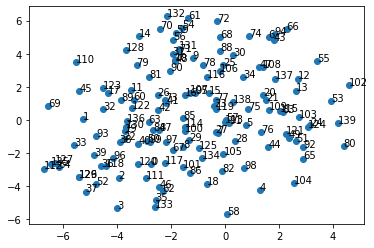

In [166]:

tsne = TSNE(n_components=2, random_state=0)
vectors = test_df["tweet_embeddings"].tolist()
Y = tsne.fit_transform(vectors)
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(test_df.index.tolist(), Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

In [102]:
sentence = "since never get reported medium want share"

In [103]:
token_list = str.split(sentence)
embedding_list = []
for token in token_list:
    try:
        embedding = embeddings_dict[token]
        embedding_list.append(embedding)
    except:
        continue

In [117]:
embed = embeddings_dict['king']

In [120]:
list(embed)

[-0.31949,
 0.10382,
 0.24294,
 -0.34845,
 -0.23829,
 -0.372,
 0.3795,
 -0.30334,
 -0.21441,
 -0.4923,
 0.098965,
 -0.13791,
 -0.80118,
 0.05041,
 0.039894,
 0.87262,
 0.44222,
 -0.32196,
 0.65187,
 0.1145,
 -0.30635,
 0.13293,
 -0.0068867,
 -0.15688,
 0.19338,
 -0.28577,
 0.2679,
 0.24383,
 0.015909,
 0.076273,
 0.58036,
 -0.071514,
 0.20632,
 -0.309,
 0.30187,
 0.129,
 -0.14297,
 -0.079204,
 0.25754,
 -0.5938,
 -0.001212,
 0.30647,
 0.833,
 -0.054968,
 0.13717,
 -0.11724,
 0.289,
 0.23425,
 0.35452,
 0.13312,
 -0.14014,
 -1.009,
 0.21142,
 0.53368,
 0.13168,
 -0.13271,
 0.25046,
 0.028531,
 -0.64371,
 0.056957,
 -0.49754,
 -0.0071232,
 -0.40831,
 -0.39913,
 -0.5956,
 -0.58436,
 0.085161,
 0.37481,
 0.082033,
 -0.32318,
 0.053241,
 -0.21014,
 -0.65141,
 -0.035154,
 0.3492,
 -0.39234,
 -0.24786,
 0.32653,
 0.21577,
 0.52755,
 0.3151,
 -0.022263,
 0.21523,
 0.67203,
 -1.0397,
 0.43497,
 -0.4411,
 0.2761,
 0.28093,
 -0.22985,
 0.93106,
 -0.066438,
 -0.0036527,
 -0.25866,
 0.37648,
 -0.05

In [119]:
type(embed)

numpy.ndarray

In [115]:
embedding.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [113]:
embedding.reshape(1).shape

ValueError: cannot reshape array of size 200 into shape (1,)

In [105]:
embedding_list.reshape(1,-1)

AttributeError: 'list' object has no attribute 'reshape'

In [106]:
embedding_array = np.array(embedding_list)
embedding_array

array([[ 0.22425  ,  0.10087  , -0.12007  , ...,  0.24304  ,  0.47749  ,
         0.12814  ],
       [-0.28163  ,  0.6649   , -0.065842 , ...,  0.30737  , -0.13003  ,
        -0.35331  ],
       [-0.20837  ,  0.37201  , -0.066035 , ..., -0.0091251, -0.26669  ,
         0.29602  ],
       ...,
       [-1.0611   , -0.20787  ,  0.21119  , ...,  0.47331  ,  0.076635 ,
        -0.44055  ],
       [ 0.31705  ,  0.51477  , -0.26564  , ...,  0.071046 ,  0.32593  ,
        -0.070306 ],
       [-0.26172  ,  0.42376  , -0.29992  , ..., -0.019416 ,  0.41491  ,
         0.26887  ]], dtype=float32)

In [62]:
averaged_array = np.average(embedding_array, axis=0)

In [140]:
averaged_array.shape[0]

200

In [58]:
type(embedding_matrix[0])

numpy.ndarray